<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 3: Practical - Neural Network <br>
<font color=696880 size=4>
    Alireza Belal
    
    
____


### Full Name : Mohammad Bagher Soltani
### Student Number : 98105813
___

# Setup

# 0. Preparation

In this part, you will use a dataset related to COVID-19. Load your dataset using pandas.

In [9]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
covid_data = pd.read_csv('./Covid Dataset.csv')
categorical_feature_mask = covid_data.dtypes == object
categorical_cols = covid_data.columns[categorical_feature_mask].tolist()
le = LabelEncoder()
covid_data[categorical_cols] = covid_data[categorical_cols].apply(lambda col: le.fit_transform(col))
covid_data = covid_data.astype(float)

# Extract X and Y from the dataset
X_total = covid_data.iloc[:, 0:20].values
y_total = covid_data.iloc[:,20].values


#SPLIT THE DATA INTO TRAIN AND TEST DATA 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size = 0.3, random_state = 0)

---------------

# 1. DNN as nonlinear dimensionality reduction method (50 Points)

Autoencoder is an unsupervised artificial neural network that compresses the data to lower dimension and then reconstructs the input back. Autoencoder finds the representation of the data in a lower dimension by focusing more on the important features getting rid of noise and redundancy. It's based on Encoder-Decoder architecture, where encoder encodes the high-dimensional data to lower-dimension and decoder takes the lower-dimensional data and tries to reconstruct the original high-dimensional data.

![picture](https://drive.google.com/uc?id=1RTZwx4xL6zFV_nUENBgWlFKLKldPoyI-)

In the above Diagram, X is the input data, z is the lower-dimension representation of input X and X’ is the reconstructed input data. The mapping of higher to lower dimensions can be linear or non-linear depending on the choice of the activation function.

In this part you're gonna implement an autoencoder using Keras framework as dimensionally reduction module as explained [here](https://blog.keras.io/building-autoencoders-in-keras.html).
(It would be ok to use PyTorch as well.)
Reduce the dimension of the data to 2 dimensions and visualize the low-dimensional data.

In [18]:
# import necessary libraries
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [12]:
# define layers (25 Points)
encoder = nn.Sequential(
    nn.Linear(in_features=20, out_features=2),
    nn.ReLU()
)
decoder = nn.Sequential(
    nn.Linear(in_features=2, out_features=20),
    nn.Sigmoid()
)
autoencoder = nn.Sequential(encoder, decoder)
autoencoder.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

In [13]:
class CovidDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return np.float32(self.data[i]), np.float32(self.labels[i])

In [14]:
train_ds = CovidDataset(data=X_train, labels=y_train)
test_ds = CovidDataset(data=X_test, labels=y_test)

batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)


In [15]:
# train the model and reduce the dimension of the data (15 Points)
num_epochs = 20
train_total_step = len(train_dl)
train_losses = []
train_accs = []
train_f1s = []

for epoch in range(num_epochs):
    train_loss = 0.0
    correct = 0
    total = 0
    conf_matrix = np.zeros((10, 10))
    with tqdm(enumerate(train_dl), total=train_total_step) as pbar:
        for i, (data, labels) in pbar:  
            optimizer.zero_grad()
            data = data.to(device)
            labels = labels.to(device)
            preds = autoencoder(data)
            outputs = torch.round(preds)
            loss = criterion(preds, data)
            total += len(data)
            train_loss += loss.detach()
            loss.backward()
            optimizer.step()
            
            correct += np.sum(outputs.detach().numpy() == data.cpu().numpy()) / 20
            acc = correct / total
            pbar.set_description(f'Train {epoch} | Loss: {train_loss/total:.3e} | Accuracy: {acc:.3f}')

    train_losses.append(train_loss / total)
    train_accs.append(correct / total)


Train 0 | Loss: 4.039e-02 | Accuracy: 0.599: 100%|██████████| 238/238 [00:00<00:00, 336.78it/s]
Train 1 | Loss: 3.731e-02 | Accuracy: 0.661: 100%|██████████| 238/238 [00:00<00:00, 372.66it/s]
Train 2 | Loss: 3.567e-02 | Accuracy: 0.677: 100%|██████████| 238/238 [00:00<00:00, 349.09it/s]
Train 3 | Loss: 3.476e-02 | Accuracy: 0.686: 100%|██████████| 238/238 [00:00<00:00, 351.55it/s]
Train 4 | Loss: 3.420e-02 | Accuracy: 0.693: 100%|██████████| 238/238 [00:00<00:00, 367.32it/s]
Train 5 | Loss: 3.381e-02 | Accuracy: 0.696: 100%|██████████| 238/238 [00:00<00:00, 330.51it/s]
Train 6 | Loss: 3.351e-02 | Accuracy: 0.696: 100%|██████████| 238/238 [00:00<00:00, 349.39it/s]
Train 7 | Loss: 3.326e-02 | Accuracy: 0.697: 100%|██████████| 238/238 [00:00<00:00, 337.41it/s]
Train 8 | Loss: 3.305e-02 | Accuracy: 0.699: 100%|██████████| 238/238 [00:00<00:00, 348.46it/s]
Train 9 | Loss: 3.287e-02 | Accuracy: 0.703: 100%|██████████| 238/238 [00:00<00:00, 353.61it/s]
Train 10 | Loss: 3.272e-02 | Accuracy: 0

In [34]:
# encode the train data

with torch.no_grad():
    encoded_data = []
    for (data, _) in train_dl:
        data = data.to(device)
        encoded = encoder(data)
        encoded_data.append(encoded)
    encoded_data = torch.cat(encoded_data)
    encoded_data = encoded_data.cpu().numpy()


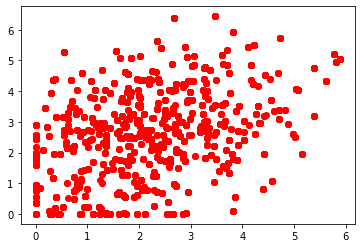

In [35]:
# Plot the encoded data (10 Points)
x_values = list(map(lambda datum: datum[0], encoded_data))
y_values = list(map(lambda datum: datum[1], encoded_data))
plt.plot(x_values, y_values,'ro')
plt.show()